In [25]:
## data handling 
import numpy as np
import pandas as pd
import random

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## ML things
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
import functions as func

## comfort things
from typing import Tuple
from sys import exit

### **Loading of the datasets** 

In [26]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

In [27]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors=2).set_output(transform="pandas")

## The imputer actually deletes columns with no data so we need to identify the columns with no data first
## We need to know those sensors to remove the associated data in the other dataframes. 
## It is needed because the values are only linked by having the same index in all dataframes.

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

test_faulty_sensors = []
for sensor in pressure_pred.columns[1:]:
    if pressure_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
    elif humidity_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
print(f'Faulty sensors in prediction datasets: {test_faulty_sensors}')
# Actually no sensors in the test dataset has no data

## We need to impute the missing values with a KNN imputer so it can be plotted a first time: 
## Which requires renaming the columns: 

## Not keeping useless columns:
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
# The sensor ID will be usefull to group the data into a numpy array

# changing the column names for faster typing later
new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)




Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']
Faulty sensors in prediction datasets: []


In [28]:

## One-hot encoding:
## cf intro to pandas notebook from the weekly exercises
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 

## the coordinates_pred is missing the columns "Material_BBLOCK" and "Material_VOID" that we have to add 
# Make a copy to be safe
df = coordinates_pred.copy()
# Create the new column with default value (e.g., 0 or NaN)
df["Material_BBLOCK"] = False  # or use np.nan if needed
df["Material_VOID"] = False
# Get column list and rearrange
cols = df.columns.tolist()
# Find index of "r"
r_index = cols.index("r")
# Insert "Material_BBLOCK" right after "r"
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]


In [29]:

## clipping:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -1500, np.nan) ##-300 initially
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= -1500, np.nan)

## Initial shapes
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = pressure_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')

## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)

## Imputing missing values (if there are some):
pressure_train = (imputer.fit_transform(pressure_train.T)).T
pressure_pred = (imputer.fit_transform(pressure_pred.T)).T

## New shapes (should be the same)
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))


pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)
101 columns in pressure_train are filled with NaN
22 columns in pressure_pred are filled with NaN
pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)


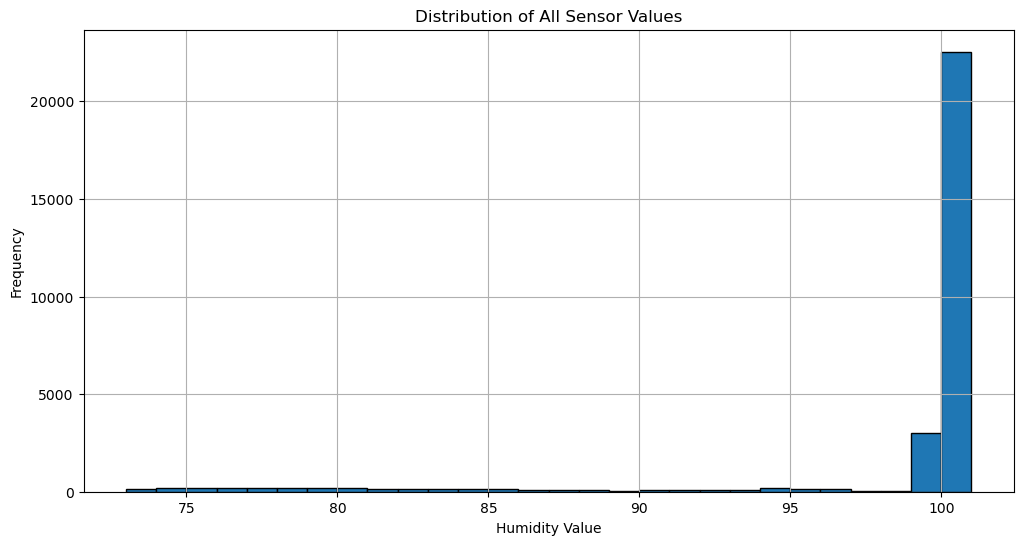

humidity_train shape:(32, 901)
humidity_pred shape:(32, 146)
0 columns in pressure_train are filled with NaN
0 columns in pressure_pred are filled with NaN


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12
x0,1554.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x1,1556.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x2,1558.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x3,1560.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x4,1563.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x5,1567.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x6,1572.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x7,1578.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x8,1585.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x9,1595.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [30]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
humidity_train = func.fill_NaN_columns(
    K = 5,
    df = humidity_train,
    imputer = imputer,
    coords = coordinates_train
)

humidity_pred = func.fill_NaN_columns(
    K = 5,
    df = humidity_pred,
    imputer = imputer,
    coords = coordinates_pred
)


## Imputing the missing data
humidity_train = (imputer.fit_transform(humidity_train.T)).T
humidity_pred = (imputer.fit_transform(humidity_pred.T)).T


# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Initial shapes
print("humidity_train shape:"+str(humidity_train.shape))
print("humidity_pred shape:"+str(humidity_pred.shape))

## Checking how many columns are filled with NaN values
count = humidity_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = humidity_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')


## Imputing the missing data
humidity_train = (imputer.fit_transform(humidity_train.T)).T
humidity_pred = (imputer.fit_transform(humidity_pred.T)).T

display(humidity_train.iloc[:,0:13])

In [31]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
temperature_train = func.fill_NaN_columns(
    K = 5,
    df = temperature_train,
    imputer = imputer,
    coords = coordinates_train
)

## We impute the missing data with the 2 nearest neighbors to view the distribution
temperature_train = (imputer.fit_transform(temperature_train.T)).T 
print(temperature_train.isnull().sum().sum()) # check that it worked

## Applying the filter:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 100, np.nan) ## set filter to 100 to see

## Initial shape: 
print(f'temperature_train shape: {temperature_train.shape}')
print(f'empty columns: {temperature_train.isnull().all().sum()}')

## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train = (imputer.fit_transform(temperature_train.T)).T

## New shape: 
print(f'temperature_train shape: {temperature_train.shape}')

0
temperature_train shape: (32, 901)
empty columns: 0
temperature_train shape: (32, 901)


In [32]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()

humidity_mean = humidity_train.iloc[:,1:].mean(axis=None) 
humidity_std = humidity_train.iloc[:,1:].values.std()

temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()

coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')

# print(f'Mean humidity: {humidity_mean}')
# print(f'SD of humidity: {humidity_std}')

# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_pred.iloc[:,1:] -= pressure_mean
pressure_pred.iloc[:,1:] /= pressure_std

humidity_train.iloc[:,1:] -= humidity_mean
humidity_train.iloc[:,1:] /= humidity_std
humidity_pred.iloc[:,1:] -= humidity_mean
humidity_pred.iloc[:,1:] /= humidity_std

temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std

coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std
coordinates_pred[["x","y","z","r"]] -= coordinates_mean
coordinates_pred[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)

assert np.isclose(humidity_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(humidity_train.iloc[:,1:].values.std(), 1)

assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)

assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



In [33]:
display(pressure_train.head(5))
display(humidity_train.head(5))
display(coordinates_train.head(5))
display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,-0.645889,0.749145,0.977854,0.584044,0.762459,0.770335,0.971657,0.807087,0.672932,...,-1.282687,-0.739008,-0.510382,-0.209060,-1.456643,-0.833363,-1.885380,-0.580330,-1.884181,0.003668
x1,1556.0,-0.647277,0.748463,0.977814,0.583651,0.762405,0.770293,0.971537,0.806948,0.672630,...,-1.283999,-0.739615,-0.510772,-0.210332,-1.457144,-0.834195,-1.886971,-0.581658,-1.885533,0.003443
x2,1558.0,-0.648661,0.747777,0.977772,0.583258,0.762351,0.770252,0.971415,0.806806,0.672328,...,-1.285155,-0.739983,-0.510885,-0.211569,-1.456848,-0.834799,-1.888528,-0.582830,-1.886452,0.003334
x3,1560.0,-0.650038,0.747085,0.977729,0.582866,0.762296,0.770212,0.971292,0.806663,0.672027,...,-1.286065,-0.739996,-0.510614,-0.212742,-1.455445,-0.835112,-1.890033,-0.583734,-1.886831,0.003386
x4,1563.0,-0.652084,0.746039,0.977663,0.582278,0.762212,0.770152,0.971106,0.806444,0.671576,...,-1.286604,-0.738819,-0.509059,-0.214254,-1.450394,-0.834827,-1.892108,-0.584158,-1.886043,0.004008


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.400404,0.324866,0.324866,0.324866,0.295353,-3.573134,0.268955,0.324866,-3.644863,0.324866
x1,1556.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.398901,0.324866,0.324866,0.324866,0.295323,-3.572826,0.268857,0.324866,-3.529004,0.324866
x2,1558.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.397208,0.324866,0.324866,0.324866,0.295343,-3.572514,0.268761,0.324866,-3.439484,0.324866
x3,1560.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.395231,0.324866,0.324866,0.324866,0.295434,-3.572195,0.268668,0.324866,-3.367152,0.324866
x4,1563.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.391427,0.324866,0.324866,0.324866,0.295757,-3.571681,0.268541,0.324866,-3.282594,0.324866


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.016937,-1.027975,-0.380302,-0.860992,False,False,False,False,True,False,False
1,N_2,-1.210408,0.141186,-0.016204,0.084301,False,False,False,False,True,False,False
2,N_3,-1.921589,-1.685009,-1.379661,1.435142,False,False,False,False,True,False,False
3,N_4,0.806761,-2.024077,-0.422075,-0.237832,False,False,False,False,True,False,False
4,N_5,0.530507,1.877074,1.497395,0.549192,False,False,False,False,True,False,False


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,-0.482682,-0.516202,-0.481358,-0.494647,-0.571554,-0.555474,-0.479869,-0.562762,-0.531245,...,-0.491199,-0.511120,-0.491603,-0.508030,-0.486227,-0.497756,-0.489603,-0.501136,-0.024854,-0.488749
x1,1556.0,-0.482839,-0.516199,-0.481351,-0.494637,-0.569032,-0.555467,-0.479861,-0.562753,-0.531233,...,-0.490710,-0.511264,-0.491582,-0.508104,-0.485837,-0.497926,-0.489846,-0.501228,0.668877,-0.488802
x2,1558.0,-0.483000,-0.516196,-0.481344,-0.494626,-0.569027,-0.555459,-0.479853,-0.562745,-0.531222,...,-0.489043,-0.511232,-0.491346,-0.511105,-0.484384,-0.498064,-0.490039,-0.501214,1.231764,-0.488804
x3,1560.0,-0.483163,-0.519605,-0.481338,-0.494616,-0.569022,-0.555451,-0.479844,-0.562737,-0.531210,...,-0.485645,-0.510902,-0.490789,-0.508187,-0.481448,-0.498146,-0.490140,-0.501025,1.704820,-0.488717
x4,1563.0,-0.483402,-0.516190,-0.481328,-0.494600,-0.569016,-0.555440,-0.479832,-0.562724,-0.531193,...,-0.475497,-0.509374,-0.488952,-0.508085,-0.473063,-0.498053,-0.489929,-0.500124,2.279636,-0.488252


Pressure's shape: (32, 901)
Humidity's shape: (32, 901)
Coordinates' shape: (900, 12)
Temperature's shape: (32, 901)


In [34]:
## Defining a KNN imputer on entire columns:
def KNN(K: int, Sensor_ID: str,data: pd.DataFrame, data_no_nan: pd.DataFrame, coords_train: pd.DataFrame, coords: pd.DataFrame) -> pd.DataFrame: 
    """
    Returns a column with the average values from the K geometrically closest sensors.

    Args: 
        K: Number of neighbors to consider.
        Sensor_ID: The sensor we want to impute.
        data_no_nan: a copy of the data but where NaN values were removed
        coords: The dataframe containing the coordinate informations.

    Returns: 
        A column with the average values from the K geometrically closest sensors
    """

    ## making a disctionnary to easily change from sensor names to indices
    sensor_dic = {i:j for i,j in enumerate(coords_train["id"])}
    ## Selecting the row of the sensor we impute
    ## Caution: the columns have to be already renamed for "id" to be found !
    point = coords[coords["id"] == Sensor_ID]
    ## has to be numpy array for broadcasting
    point = point[["x","y","z"]].to_numpy() 

    ## taking the coordinates of all the other sensors
    all_others = coords_train[["x","y","z"]]

    ## computing the distance of the sensor to all others
    distances = np.sum((all_others - point)**2, axis = 1)

    ## sorting in ascending order
    distances = distances.sort_values()

    sensors = []
    i = 0
    while  len(sensors) < K:

        ## selecting the closest sensor (index 0 is the sensor itself at a distance 0)
        distance = distances.copy().to_list()[i+1] 
        
        ## Converting sensor index back to string
        ## the length of distances.copy().to_list() match with distances.shape[0] so the index is the right one
        assert len(distances.copy().to_list()) == distances.shape[0]
        sensor = sensor_dic[distances[distances == distance].index[0]]

        ## making sure we copy a sensor that has values
        if sensor in data.columns: 
            sensors.append(sensor)

        i += 1

    #try:
    values = data[sensors]
    # except: 
    #     display(data)
    #     print(data.columns.tolist())
    #     # display(data[sensor[0]])
    
    return  1/K * np.sum(values, axis = 1) # return the average

In [35]:
X_t_pred = {}
sensor_IDs = pressure_pred.columns[1:]
# columns = np.array(["id"])
# t = np.array(pressure_pred['M.Time[d]'].to_list(), dtype = np.int32)
# print(columns.shape)
# print(t.shape)
# columns = np.concatenate([columns, t])
# print(columns)
# print(columns.shape)
pred = pd.DataFrame(data = sensor_IDs, columns=["id"])
pred = pred.T

for i, t in enumerate(pressure_pred['M.Time[d]']): 
    ## first, selsect the pressure data at the time
    X = pressure_pred.iloc[i, 1:]
    H = humidity_pred.iloc[i,1:]
    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))

    ## then add the coordinates and material features to the array 
    coords = coordinates_pred.iloc[:,1:].to_numpy()
    X = np.concatenate([X,H,coords], axis = 1)
    ## add it to the dictionnary
    X_t_pred[t] = X


predictions = {}  # store each column's predictions
for i, sensor in enumerate(sensor_IDs):

    y_sens = KNN(
        K = 7,
        Sensor_ID = sensor,
        data = temperature_train,
        data_no_nan = imputer.fit_transform(pressure_pred),
        coords_train = coordinates_train,
        coords = coordinates_pred
    )

    y_sens = y_sens*temperature_std + np.ones(y_sens.shape[0])*temperature_mean
    predictions[sensor] = pd.Series(y_sens, name=sensor)

pred = pd.concat(predictions.values(), axis=1)
pred = pred.T
pred.columns = np.array(pressure_pred['M.Time[d]'].tolist(), dtype = np.int32)

display(pred)
pred.to_csv("data\\submission.csv", index=True)
 
## ADD "id" to the first entry in the csv !!!!

,1554,1556,1558,1560,1563,1567,1572,1578,1585,1595,...,2395,2607,2871,3202,3616,4133,4779,5587,6597,7028
N_901,17.445422,17.906063,18.422217,18.961404,19.777643,20.838089,22.091260,23.478217,24.931093,26.755095,...,49.652059,50.993164,52.202366,53.303926,54.299418,55.348429,55.966200,56.658482,57.265086,57.470221
N_902,17.208931,17.226747,17.207784,17.210451,17.222811,17.258407,17.335771,17.474094,17.688426,18.072199,...,33.621376,34.918118,36.112319,37.221091,38.241474,39.165763,40.001058,40.758234,41.441321,41.677181
N_903,18.467167,19.916164,21.154457,22.258633,23.722751,25.446468,27.343041,29.264544,31.340771,33.723161,...,53.208700,54.327036,55.513506,56.588843,57.553081,58.293660,59.133901,59.765510,60.293775,60.464689
N_904,17.446301,17.444195,17.442341,17.440966,17.440920,17.446578,17.465487,17.507373,17.581878,17.731715,...,25.808209,26.645243,27.464346,28.269095,29.049717,29.792174,30.492721,31.152417,31.768688,31.986118
N_905,17.243662,17.242052,17.241170,17.241544,17.246728,17.265064,17.308892,17.391823,17.525084,17.770052,...,27.859786,28.813158,29.731269,30.620382,31.471831,32.272613,33.021175,33.720558,34.369309,34.597179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N_1042,17.332346,17.412914,17.544330,17.727226,18.052185,18.138837,19.311213,20.448071,21.290269,22.758527,...,44.797628,46.107063,47.299499,47.809516,49.402370,50.307408,51.120945,51.854474,52.512773,52.739541
N_1043,17.395486,17.393583,17.392260,17.391985,17.403333,17.410771,17.449167,17.524027,17.646493,17.874394,...,27.082451,27.960761,28.813958,29.646809,30.449999,31.209861,31.923477,32.592727,33.215606,33.434880
N_1044,17.201971,17.200980,17.201586,17.204552,17.216175,17.246638,17.308782,17.415129,17.574881,17.853175,...,28.353466,29.331499,30.270422,31.177066,32.042990,32.855411,33.613318,34.320340,34.975469,35.205461
N_1045,17.367014,17.419884,17.544494,17.688187,17.950615,18.318110,18.841966,19.435606,20.098511,20.977496,...,37.054256,38.206798,39.279990,40.287963,41.226001,42.084527,42.867829,43.584985,44.239671,44.467815


In [ ]:
## 3 neighbors: 99.7 score
## 5 neighbors: 92.6 score
## 7 neighbors: 81.5 score